In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Colab Notebooks

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error

In [ ]:
# Load dataset
df = pd.read_csv('CO2n.csv', nrows=10000, encoding='utf-8-sig')

# Extract target variables
y = df[['CO2']]
X = df.drop(['Date', 'AP', 'RAD' ,'CO2'], axis=1)

In [ ]:
X.head()

,AT,RH,WS,SM_20,ST_20
0,16.6,67.6,1.2,16.1,14.7
1,14.5,74.7,2.9,15.8,15.1
2,16.3,61.6,2.0,15.4,15.1
3,14.5,69.1,2.2,15.4,15.6
4,14.2,62.3,3.9,16.2,15.2


In [ ]:
# Split into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


In [ ]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

#  Perform RFE
# Initialize the RFE selector with a Linear Regression model and specify the number of features to select
rfe_selector = RFE(estimator=LinearRegression(), n_features_to_select=5)

# Fit the RFE selector to the training data
rfe_selector.fit(X_train, y_train)

# Get the selected features
selected_features = X_train.columns[rfe_selector.support_]

print("Selected features by RFE:")
print(selected_features)

Selected features by RFE:
Index(['AT', 'RH', 'WS', 'SM_20', 'ST_20'], dtype='object')


# MLGRIDSEARCH

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor


# Step 1: Define Models and Parameter Grids

# Linear Regression (no hyperparameters to tune with GridSearchCV)
#lr = MultiOutputRegressor(LinearRegression())
#lr_param_grid = {}

# KNN Regressor
knn = MultiOutputRegressor(KNeighborsRegressor())
knn_param_grid = {'estimator__n_neighbors': [3, 5, 7, 9]}

# Random Forest Regressor
rf = MultiOutputRegressor(RandomForestRegressor(random_state=42))
rf_param_grid = {'estimator__n_estimators': [50, 100, 150],
                 'estimator__max_depth': [None, 10, 20]}

# Gradient Boosting Regressor
gbr = MultiOutputRegressor(GradientBoostingRegressor(random_state=42))
gbr_param_grid = {'estimator__n_estimators': [50, 100, 150],
                  'estimator__learning_rate': [0.01, 0.1,],
                  'estimator__max_depth': [3, 5, 7]}


# XGBoost Regressor
xgb = MultiOutputRegressor(XGBRegressor(random_state=42))
xgb_param_grid = {'estimator__n_estimators': [50, 100, 150],
                  'estimator__learning_rate': [0.01, 0.1,],
                  'estimator__max_depth': [3, 5,]}

# Ridge Regressor
ridge = MultiOutputRegressor(Ridge(random_state=42))
ridge_param_grid = {'estimator__alpha': [0.1, 1.0, 10.0]}

# LASSO Regressor
lasso = MultiOutputRegressor(Lasso(random_state=42))
lasso_param_grid = {'estimator__alpha': [0.1, 1.0, 10.0]}

# SVR (Support Vector Regressor) - Note: SVR can be computationally expensive
svr = MultiOutputRegressor(SVR())
svr_param_grid = {'estimator__C': [0.1, 1.0, 10.0],
                  'estimator__epsilon': [0.01, 0.1, 0.2]}

# MLP Regressor (Neural Network)
mlp = MultiOutputRegressor(MLPRegressor(random_state=42))
mlp_param_grid = {'estimator__hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],
                  'estimator__activation': ['relu', 'tanh', 'logistic'],
                  'estimator__solver': ['adam', 'sgd'],
                  'estimator__learning_rate_init': [0.001, 0.01, 0.1],
                  'estimator__max_iter': [1000, 2000, 3000]}


models_grid = [
    #(lr, lr_param_grid, 'Linear Regression'),
    (knn, knn_param_grid, 'KNN'),
    (rf, rf_param_grid, 'Random Forest'),
    (gbr, gbr_param_grid, 'Gradient Boosting'),
    (xgb, xgb_param_grid, 'XGBoost'),
    (ridge, ridge_param_grid, 'Ridge'),
    (lasso, lasso_param_grid, 'LASSO'),
    (svr, svr_param_grid, 'SVR'),
    (mlp, mlp_param_grid, 'MLP'),
]

In [ ]:
# Step 2: Implement Grid Search with Cross-Validation and Capture All Metrics

optimized_models = {}
results_list = []

for model, param_grid, name in models_grid:
    print(f"Running GridSearchCV for {name}...")
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    grid_search.fit(X_train, y_train)

    best_model = grid_search.best_estimator_
    optimized_models[name] = best_model

    print(f"Best parameters for {name}: {grid_search.best_params_}")

    # Evaluate the best model on the train, validation, and test sets
    y_train_pred = best_model.predict(X_train)
    y_val_pred = best_model.predict(X_val)
    y_test_pred = best_model.predict(X_test)


    # Calculate metrics for each output on train, validation, and test sets
    model_results = {'Model': name}
    for i, col in enumerate(y_test.columns): # Assuming the same columns for train, val, test
        model_results[f'{col}_Train_RMSE'] = np.sqrt(mean_squared_error(y_train[col], y_train_pred[:, i]))
        model_results[f'{col}_Train_R2'] = r2_score(y_train[col], y_train_pred[:, i])
        model_results[f'{col}_Train_MAE'] = mean_absolute_error(y_train[col], y_train_pred[:, i])
        model_results[f'{col}_Train_MAPE'] = mean_absolute_percentage_error(y_train[col], y_train_pred[:, i])

        model_results[f'{col}_Val_RMSE'] = np.sqrt(mean_squared_error(y_val[col], y_val_pred[:, i]))
        model_results[f'{col}_Val_R2'] = r2_score(y_val[col], y_val_pred[:, i])
        model_results[f'{col}_Val_MAE'] = mean_absolute_error(y_val[col], y_val_pred[:, i])
        model_results[f'{col}_Val_MAPE'] = mean_absolute_percentage_error(y_val[col], y_val_pred[:, i])


        model_results[f'{col}_Test_RMSE'] = np.sqrt(mean_squared_error(y_test[col], y_test_pred[:, i]))
        model_results[f'{col}_Test_R2'] = r2_score(y_test[col], y_test_pred[:, i])
        model_results[f'{col}_Test_MAE'] = mean_absolute_error(y_test[col], y_test_pred[:, i])
        model_results[f'{col}_Test_MAPE'] = mean_absolute_percentage_error(y_test[col], y_test_pred[:, i])


    results_list.append(model_results)

print("Grid search optimization and evaluation completed.")

Running GridSearchCV for KNN...
Best parameters for KNN: {'estimator__n_neighbors': 5}
Running GridSearchCV for Random Forest...
Best parameters for Random Forest: {'estimator__max_depth': 10, 'estimator__n_estimators': 150}
Running GridSearchCV for Gradient Boosting...
Best parameters for Gradient Boosting: {'estimator__learning_rate': 0.1, 'estimator__max_depth': 3, 'estimator__n_estimators': 50}
Running GridSearchCV for XGBoost...
Best parameters for XGBoost: {'estimator__learning_rate': 0.1, 'estimator__max_depth': 5, 'estimator__n_estimators': 50}
Running GridSearchCV for Ridge...
Best parameters for Ridge: {'estimator__alpha': 10.0}
Running GridSearchCV for LASSO...
Best parameters for LASSO: {'estimator__alpha': 0.1}
Running GridSearchCV for SVR...
Best parameters for SVR: {'estimator__C': 10.0, 'estimator__epsilon': 0.1}
Running GridSearchCV for MLP...
Best parameters for MLP: {'estimator__activation': 'logistic', 'estimator__hidden_layer_sizes': (100,), 'estimator__learning_ra

In [ ]:
# Step 3: Compare Model Performance and Export All Metrics

results_df_optimized_all_metrics = pd.DataFrame(results_list)
print("Optimized Model Performance (Train, Validation, and Test Sets):")
print(results_df_optimized_all_metrics)

# Export all evaluation metrics to CSV in the CO2 folder
results_df_optimized_all_metrics.to_csv('CO2/optimized_model_performance_all_metrics.csv', index=False)
print("Optimized model performance (all metrics) exported to CO2/optimized_model_performance_all_metrics.csv")

Optimized Model Performance (Train, Validation, and Test Sets):
               Model  CO2_Train_RMSE  CO2_Train_R2  CO2_Train_MAE  \
0                KNN       14.523088      0.778511      10.387394   
1      Random Forest        6.779026      0.951742       4.954354   
2  Gradient Boosting       10.464455      0.885008       7.739891   
3            XGBoost        5.212346      0.971470       3.922178   
4              Ridge       21.383813      0.519819      15.889650   
5              LASSO       21.384032      0.519809      15.888254   
6                SVR       22.777077      0.455208      16.255511   
7                MLP       19.453792      0.602586      14.730729   

   CO2_Train_MAPE  CO2_Val_RMSE  CO2_Val_R2  CO2_Val_MAE  CO2_Val_MAPE  \
0        0.034333     22.132645    0.559170    15.001690      0.047099   
1        0.016648     17.201444    0.733723    12.396471      0.039920   
2        0.026125     16.486832    0.755387    12.434994      0.040169   
3        0.013386 

In [ ]:
# Step 4: Generate Predictions for All Models

all_predictions = {}

for name, model in optimized_models.items():
    print(f"Generating predictions for {name}...")
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)
    y_test_pred = model.predict(X_test)

    all_predictions[name] = {
        'train': y_train_pred,
        'val': y_val_pred,
        'test': y_test_pred
    }

print("Prediction generation completed.")

Generating predictions for KNN...
Generating predictions for Random Forest...
Generating predictions for Gradient Boosting...
Generating predictions for XGBoost...
Generating predictions for Ridge...
Generating predictions for LASSO...
Generating predictions for SVR...
Generating predictions for MLP...
Prediction generation completed.


In [ ]:
# Step 5: Retrieve Dates for Each Set

train_dates = df.loc[X_train.index, 'Date']
val_dates = df.loc[X_val.index, 'Date']
test_dates = df.loc[X_test.index, 'Date']

print("Dates retrieved for train, validation, and test sets.")

Dates retrieved for train, validation, and test sets.


In [ ]:
# Step 6: Prepare and Export DataFrames

for model_name, predictions in all_predictions.items():
    print(f"Exporting predictions for {model_name}...")

    # Train set
    train_df_export = pd.DataFrame({
        'Date': train_dates,
        'Actual_CO2': y_train['CO2'],
        'Predicted_CO2': predictions['train'].flatten() # Flatten in case of multi-output but single target
    })
    train_df_export.to_csv(f'CO2/{model_name.replace(" ", "_")}_train_predictions.csv', index=False)

    # Validation set
    val_df_export = pd.DataFrame({
        'Date': val_dates,
        'Actual_CO2': y_val['CO2'],
        'Predicted_CO2': predictions['val'].flatten()
    })
    val_df_export.to_csv(f'CO2/{model_name.replace(" ", "_")}_val_predictions.csv', index=False)

    # Test set
    test_df_export = pd.DataFrame({
        'Date': test_dates,
        'Actual_CO2': y_test['CO2'],
        'Predicted_CO2': predictions['test'].flatten()
    })
    test_df_export.to_csv(f'CO2/{model_name.replace(" ", "_")}_test_predictions.csv', index=False)

print("Prediction export completed.")

Exporting predictions for KNN...
Exporting predictions for Random Forest...
Exporting predictions for Gradient Boosting...
Exporting predictions for XGBoost...
Exporting predictions for Ridge...
Exporting predictions for LASSO...
Exporting predictions for SVR...
Exporting predictions for MLP...
Prediction export completed.


# **PART2**

In [ ]:
# Step 1: Select Base Models

# Sort the results by Test R2 in descending order
sorted_models = results_df_optimized_all_metrics.sort_values(by='CO2_Test_R2', ascending=False)

# Select the top 3 models
selected_base_model_names = sorted_models['Model'].head(3).tolist()


print("Top 3 base models selected for stacking:")
print(selected_base_model_names)

# Retrieve the actual model objects from the optimized_models dictionary
selected_base_models = [(name, optimized_models[name]) for name in selected_base_model_names]

Top 3 base models selected for stacking:
['Random Forest', 'Gradient Boosting', 'XGBoost']


In [ ]:
# Step 2: Prepare Data for Stacking

from sklearn.model_selection import KFold

# Define the number of folds
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

print(f"Training data split into {n_splits} folds for stacking.")

Training data split into 5 folds for stacking.


In [ ]:
# Step 3: Train Base Models and Generate Out-of-Fold Predictions

oof_train_preds = np.zeros((X_train.shape[0], len(selected_base_models)))

for i, (name, model) in enumerate(selected_base_models):
    print(f"Generating out-of-fold predictions for {name}...")
    oof_preds = np.zeros((X_train.shape[0],))
    for fold, (train_idx, val_idx) in enumerate(kf.split(X_train, y_train)):
        X_train_fold, y_train_fold = X_train.iloc[train_idx], y_train.iloc[train_idx]
        X_val_fold, y_val_fold = X_train.iloc[val_idx], y_train.iloc[val_idx]

        model.fit(X_train_fold, y_train_fold)
        oof_preds[val_idx] = model.predict(X_val_fold).flatten() # Flatten in case of multi-output but single target

    oof_train_preds[:, i] = oof_preds

print("Out-of-fold prediction generation completed.")

Generating out-of-fold predictions for Random Forest...
Generating out-of-fold predictions for Gradient Boosting...
Generating out-of-fold predictions for XGBoost...
Out-of-fold prediction generation completed.


In [ ]:
# Step 4: Generate Test Predictions from Base Models

test_preds_base_models = np.zeros((X_test.shape[0], len(selected_base_models)))

for i, (name, model) in enumerate(selected_base_models):
    print(f"Generating test predictions for {name}...")
    # Train the base model on the full training data
    model.fit(X_train, y_train)
    # Generate predictions on the test set
    test_preds_base_models[:, i] = model.predict(X_test).flatten() # Flatten in case of multi-output but single target

print("Test prediction generation from base models completed.")

Generating test predictions for Random Forest...
Generating test predictions for Gradient Boosting...
Generating test predictions for XGBoost...
Test prediction generation from base models completed.


In [ ]:
# Step 5 (Optimized): Train Ridge as Meta-Learner with GridSearchCV

# Define Ridge Regressor as the meta-learner
ridge_meta_learner = Ridge(random_state=42)

# Define the parameter grid for Ridge
ridge_param_grid_meta = {
    'alpha': [0.1, 1.0, 10.0, 100.0] # Experiment with different alpha values
}

# Initialize GridSearchCV
grid_search_meta = GridSearchCV(ridge_meta_learner, ridge_param_grid_meta, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Fit GridSearchCV to the out-of-fold predictions
grid_search_meta.fit(oof_train_preds, y_train)

# Get the best meta-learner model
meta_learner_ridge_optimized = grid_search_meta.best_estimator_

print("Optimized Ridge meta-learner training completed.")
print("Best parameters for Ridge meta-learner:", grid_search_meta.best_params_)
# Step 6: Generate Final Predictions

stacked_test_preds = meta_learner_ridge_optimized.predict(test_preds_base_models)

print("Final stacked model predictions generated.")


Optimized Ridge meta-learner training completed.
Best parameters for Ridge meta-learner: {'alpha': 100.0}
Final stacked model predictions generated.


In [ ]:
# Step 7: Evaluate Stacked Model

stacked_test_rmse = np.sqrt(mean_squared_error(y_test, stacked_test_preds))
stacked_test_r2 = r2_score(y_test, stacked_test_preds)
stacked_test_mae = mean_absolute_error(y_test, stacked_test_preds)
stacked_test_mape = mean_absolute_percentage_error(y_test, stacked_test_preds)

print("Stacked Model Test RMSE:", stacked_test_rmse)
print("Stacked Model Test R2:", stacked_test_r2)
print("Stacked Model Test MAE:", stacked_test_mae)
print("Stacked Model Test MAPE:", stacked_test_mape)

# Step 8: Compare Stacked Model Performance

#stacked_results = {
 #   'Model': 'Stacked Model (Ridge Meta-Learner)',
  #  'CO2_Train_RMSE': np.nan, # Not directly calculated in this stacking approach
   # 'CO2_Train_R2': np.nan,   # Not directly calculated
  #  'CO2_Train_MAE': np.nan,  # Not directly calculated
   # 'CO2_Train_MAPE': np.nan, # Not directly calculated
    #'CO2_Val_RMSE': np.nan,   # Not directly calculated
    #'#CO2_Val_R2': np.nan,     # Not directly calculated
    #'CO2_Val_MAE': np.nan,    # Not directly calculated
    #'CO2_Val_MAPE': np.nan,   # Not directly calculated
    #'CO2_Test_RMSE': stacked_test_rmse,
    #'CO2_Test_R2': stacked_test_r2,
    #'CO2_Test_MAE': stacked_test_mae,
    #'CO2_Test_MAPE': stacked_test_mape
#}

#results_df_optimized_all_metrics = pd.concat([results_df_optimized_all_metrics, pd.DataFrame([stacked_results])], ignore_index=True)

#print("\nOptimized Model Performance (Including Stacked Model):")
#print(results_df_optimized_all_metrics)

Stacked Model Test RMSE: 14.79464845460485
Stacked Model Test R2: 0.7825343986947295
Stacked Model Test MAE: 11.110234924622914
Stacked Model Test MAPE: 0.036615149495426796


In [ ]:
# Step 9: Generate Stacked Predictions for Train and Validation

# Generate base model predictions on the train set (using base models trained on the full train set)
train_preds_base_models = np.zeros((X_train.shape[0], len(selected_base_models)))
for i, (name, model) in enumerate(selected_base_models):
    train_preds_base_models[:, i] = model.predict(X_train).flatten()

# Generate stacked predictions on the train set using the Ridge meta-learner
stacked_train_preds = meta_learner_ridge_optimized.predict(train_preds_base_models)


# Generate base model predictions on the validation set (using base models trained on the full train set)
val_preds_base_models = np.zeros((X_val.shape[0], len(selected_base_models)))
for i, (name, model) in enumerate(selected_base_models):
    val_preds_base_models[:, i] = model.predict(X_val).flatten()

# Generate stacked predictions on the validation set using the Ridge meta-learner
stacked_val_preds = meta_learner_ridge_optimized.predict(val_preds_base_models)

print("Stacked predictions generated for train and validation sets.")

Stacked predictions generated for train and validation sets.


In [ ]:
# Step 10: Prepare DataFrames for Stacked Predictions

# Train set DataFrame
stacked_train_df_export = pd.DataFrame({
    'Date': train_dates,
    'Actual_CO2': y_train['CO2'],
    'Predicted_CO2': stacked_train_preds.flatten() # Flatten in case of multi-output but single target
})

# Validation set DataFrame
stacked_val_df_export = pd.DataFrame({
    'Date': val_dates,
    'Actual_CO2': y_val['CO2'],
    'Predicted_CO2': stacked_val_preds.flatten()
})

# Test set DataFrame
stacked_test_df_export = pd.DataFrame({
    'Date': test_dates,
    'Actual_CO2': y_test['CO2'],
    'Predicted_CO2': stacked_test_preds.flatten()
})

print("DataFrames for stacked predictions created.")

DataFrames for stacked predictions created.


In [ ]:
# Step 11: Export Stacked Prediction DataFrames to CSV

stacked_train_df_export.to_csv('CO2/stacked_model_ridge_train_predictions.csv', index=False)
print("Stacked train predictions exported to CO2/stacked_model_ridge_train_predictions.csv")

stacked_val_df_export.to_csv('CO2/stacked_model_ridge_val_predictions.csv', index=False)
print("Stacked validation predictions exported to CO2/stacked_model_ridge_val_predictions.csv")

stacked_test_df_export.to_csv('CO2/stacked_model_ridge_test_predictions.csv', index=False)
print("Stacked test predictions exported to CO2/stacked_model_ridge_test_predictions.csv")

Stacked train predictions exported to CO2/stacked_model_ridge_train_predictions.csv
Stacked validation predictions exported to CO2/stacked_model_ridge_val_predictions.csv
Stacked test predictions exported to CO2/stacked_model_ridge_test_predictions.csv


In [ ]:
#step 12 Calculate and display evaluation metrics for the stacked model on Train, Validation, and Test sets

# Train set metrics
stacked_train_rmse = np.sqrt(mean_squared_error(y_train, stacked_train_preds))
stacked_train_r2 = r2_score(y_train, stacked_train_preds)
stacked_train_mae = mean_absolute_error(y_train, stacked_train_preds)
stacked_train_mape = mean_absolute_percentage_error(y_train, stacked_train_preds)

print("Stacked Model Train RMSE:", stacked_train_rmse)
print("Stacked Model Train R2:", stacked_train_r2)
print("Stacked Model Train MAE:", stacked_train_mae)
print("Stacked Model Train MAPE:", stacked_train_mape)
print("-" * 30)

# Validation set metrics
stacked_val_rmse = np.sqrt(mean_squared_error(y_val, stacked_val_preds))
stacked_val_r2 = r2_score(y_val, stacked_val_preds)
stacked_val_mae = mean_absolute_error(y_val, stacked_val_preds)
stacked_val_mape = mean_absolute_percentage_error(y_val, stacked_val_preds)

print("Stacked Model Val RMSE:", stacked_val_rmse)
print("Stacked Model Val R2:", stacked_val_r2)
print("Stacked Model Val MAE:", stacked_val_mae)
print("Stacked Model Val MAPE:", stacked_val_mape)
print("-" * 30)

# Test set metrics (already calculated, but displaying again for completeness)
print("Stacked Model Test RMSE:", stacked_test_rmse)
print("Stacked Model Test R2:", stacked_test_r2)
print("Stacked Model Test MAE:", stacked_test_mae)
print("Stacked Model Test MAPE:", stacked_test_mape)

Stacked Model Train RMSE: 7.125966824798866
Stacked Model Train R2: 0.9466760590711418
Stacked Model Train MAE: 5.321410573898679
Stacked Model Train MAPE: 0.017947139634923052
------------------------------
Stacked Model Val RMSE: 16.75716682940104
Stacked Model Val R2: 0.7472998177700261
Stacked Model Val MAE: 12.047494081091868
Stacked Model Val MAPE: 0.03875482374703065
------------------------------
Stacked Model Test RMSE: 14.79464845460485
Stacked Model Test R2: 0.7825343986947295
Stacked Model Test MAE: 11.110234924622914
Stacked Model Test MAPE: 0.036615149495426796


# **SHAP EXPLANATION**

In [ ]:
%pip install shap

In [ ]:
# Step 2: Define Stacked Model Prediction Function

def stacked_model_predict(X):
    """
    Prediction function for the stacked model that takes original features (X)
    and returns the final stacked predictions.
    """
    # Ensure X is a pandas DataFrame to use .iloc for indexing in base models
    if not isinstance(X, pd.DataFrame):
        X = pd.DataFrame(X, columns=X_train.columns) # Assuming column names are consistent

    # Generate predictions from base models
    base_model_preds = np.zeros((X.shape[0], len(selected_base_models)))
    for i, (name, model) in enumerate(selected_base_models):
        base_model_preds[:, i] = model.predict(X).flatten()

    # Generate final predictions using the meta-learner
    final_predictions = meta_learner_ridge_optimized.predict(base_model_preds)

    return final_predictions.flatten() # Return flattened predictions

In [ ]:
# Step 3: Prepare Data for SHAP and Initialize Explainer

import shap

# Select data subsets for explanation
# Using the full datasets as requested. Be aware that Kernel SHAP can be computationally intensive.
X_train_sample = X_train # Use full training data for SHAP explanation
X_val_sample = X_val   # Use full validation data for SHAP explanation
X_test_sample = X_test   # Use full test data for SHAP explanation


# Use a background dataset for the explainer (e.g., a small sample of the training data)
# A smaller background dataset is generally sufficient and helps reduce computation time.
background_data = X_train.sample(min(200, len(X_train)), random_state=42)


# Initialize the Kernel SHAP explainer
# Passing the prediction function and the background dataset
explainer = shap.KernelExplainer(stacked_model_predict, background_data)

print("Data subsets prepared and SHAP Kernel Explainer initialized.")

Data subsets prepared and SHAP Kernel Explainer initialized.


In [ ]:
# Step 4: Compute SHAP Values

print("Computing SHAP values for train sample...")
shap_values_train = explainer.shap_values(X_train_sample)

print("Computing SHAP values for validation sample...")
shap_values_val = explainer.shap_values(X_val_sample)

print("Computing SHAP values for test sample...")
shap_values_test = explainer.shap_values(X_test_sample)

print("SHAP value computation completed.")

Computing SHAP values for train sample...


  0%|          | 0/330 [00:00<?, ?it/s]

Computing SHAP values for validation sample...


  0%|          | 0/71 [00:00<?, ?it/s]

Computing SHAP values for test sample...


  0%|          | 0/71 [00:00<?, ?it/s]

SHAP value computation completed.


Generating SHAP summary plot (bar) for the test sample and exporting to JPEG...


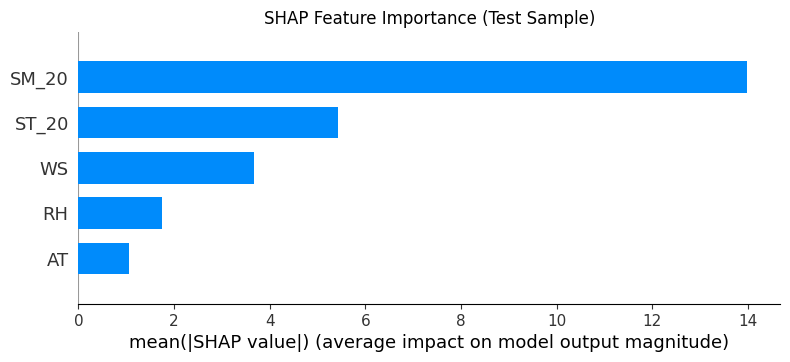

Generating SHAP summary plot (default) for the test sample and exporting to JPEG...


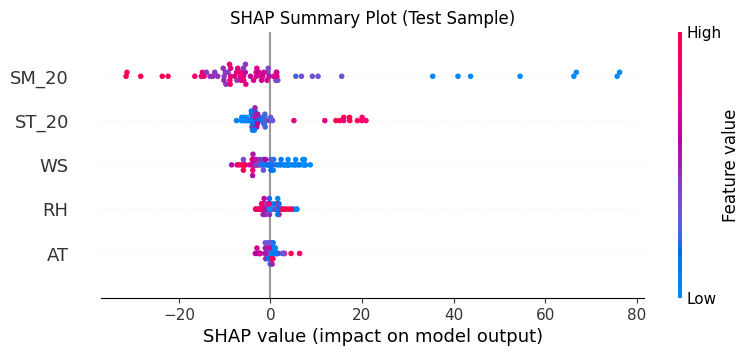

SHAP summary plots generated and exported to CO2 folder.


In [ ]:
# Step 5: Generate SHAP Summary Plot (for Test Sample)

import matplotlib.pyplot as plt
import os

# Create the CO2 folder if it doesn't exist
if not os.path.exists('CO2'):
    os.makedirs('CO2')

print("Generating SHAP summary plot (bar) for the test sample and exporting to JPEG...")
# Use plot_type="bar" for overall feature importance
shap.summary_plot(shap_values_test, X_test_sample, plot_type="bar", show=False)
plt.title("SHAP Feature Importance (Test Sample)")
plt.savefig('CO2/shap_feature_importance_bar.jpeg', dpi=350, bbox_inches='tight')
plt.show() # Display the plot in the notebook
plt.close() # Close the plot to prevent it from displaying twice

print("Generating SHAP summary plot (default) for the test sample and exporting to JPEG...")
# Default summary plot showing impact and direction
shap.summary_plot(shap_values_test, X_test_sample, show=False)
plt.title("SHAP Summary Plot (Test Sample)")
plt.savefig('CO2/shap_summary_plot.jpeg', dpi=350, bbox_inches='tight')
plt.show() # Display the plot in the notebook
plt.close() # Close the plot

print("SHAP summary plots generated and exported to CO2 folder.")

# Dependence plot

Generating SHAP dependence plots for the top 3 features and exporting to JPEG...


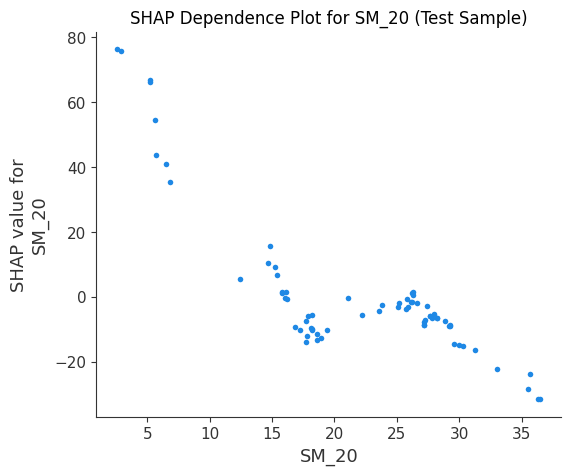

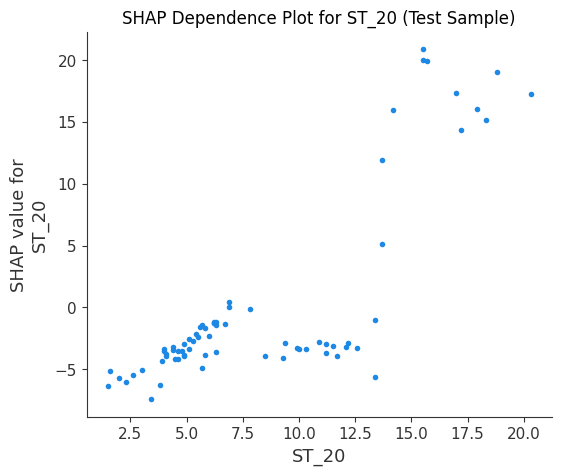

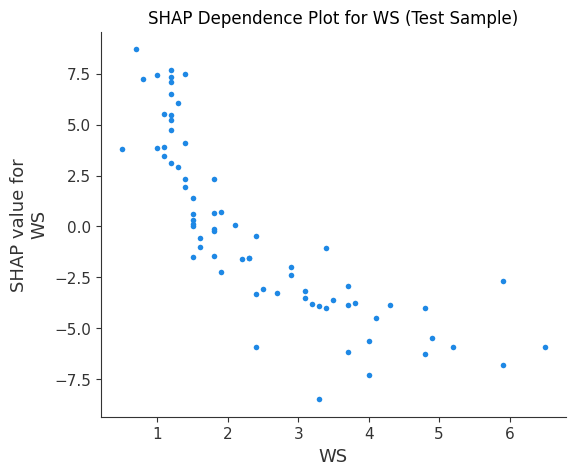

SHAP dependence plots generated and exported to CO2 folder.


In [ ]:
# Step 6: Generate SHAP Dependence Plots (for key features in Test Sample)

# Identify the top features from the summary plot (e.g., based on the bar plot)
# Let's assume the features are sorted by importance in the bar plot.
# We can pick a few of the top features to visualize.
top_features = X_test_sample.columns[np.argsort(np.abs(shap_values_test).mean(0))[::-1]]

# Choose the top N features to plot dependence for
num_dependence_plots = min(3, len(top_features)) # Plot for top 3 features or fewer if less than 3

print(f"Generating SHAP dependence plots for the top {num_dependence_plots} features and exporting to JPEG...")

for i in range(num_dependence_plots):
    shap.dependence_plot(top_features[i], shap_values_test, X_test_sample, interaction_index=None, show=False)
    plt.title(f"SHAP Dependence Plot for {top_features[i]} (Test Sample)")
    plt.savefig(f'CO2/shap_dependence_plot_{top_features[i]}.jpeg', dpi=350, bbox_inches='tight')
    plt.show() # Display the plot in the notebook
    plt.close() # Close the plot

print("SHAP dependence plots generated and exported to CO2 folder.")

# Force plot

In [ ]:
# Generate SHAP Force Plot for a single instance (e.g., the first instance in the test set)

# Select the instance you want to explain (e.g., the first instance)
instance_idx = 0
instance_to_explain = X_test_sample.iloc[[instance_idx]]
shap_values_instance = explainer.shap_values(instance_to_explain)

print(f"Generating SHAP force plot for instance at index {instance_idx} in the test sample and exporting to JPEG...")

# Visualize the force plot
shap.initjs() # Initialize JavaScript visualization in Colab
# The force plot is interactive and cannot be directly saved as a static image using plt.savefig in the same way.
# We will generate the HTML output which can be saved manually or by using other libraries if needed for static export.
# For now, the force plot will be displayed as an interactive visualization.
force_plot_html = shap.force_plot(explainer.expected_value, shap_values_instance, instance_to_explain, show=False).html()

# To save the force plot as an image programmatically, you would typically need
# to render the HTML in a headless browser or use libraries designed for this,
# which is more complex than direct saving.
# As a workaround, you can display the plot and save it manually, or we can
# generate the HTML and you can save that.
# Let's display the HTML output.
display(HTML(force_plot_html))

print("SHAP force plot generated (interactive HTML).")

  0%|          | 0/1 [00:00<?, ?it/s]

Generating SHAP force plot for instance at index 0 in the test sample and exporting to JPEG...


SHAP force plot generated (interactive HTML).


In [ ]:
from IPython.display import HTML

# Find the instance with the median predicted value in the test set

# Calculate the median of the stacked test predictions
median_prediction = np.median(stacked_test_preds)

# Find the index of the instance in the test set with the prediction closest to the median
# We find the absolute difference between each prediction and the median prediction,
# and then get the index of the minimum difference.
closest_instance_index_in_test_sample = np.argmin(np.abs(stacked_test_preds - median_prediction))

# Get the actual instance data from the test sample using this index
instance_to_explain_median = X_test_sample.iloc[[closest_instance_index_in_test_sample]]

# Get the SHAP values for this specific instance from the pre-computed SHAP values for the test sample
shap_values_median_instance = shap_values_test[closest_instance_index_in_test_sample]

print(f"Generating SHAP force plot for the instance with a prediction closest to the median predicted value ({median_prediction:.2f}) and exporting to JPEG...")

# Visualize the force plot for the median instance
shap.initjs() # Initialize JavaScript visualization in Colab
# The force plot is interactive and cannot be directly saved as a static image using plt.savefig in the same way.
# We will generate the HTML output which can be saved manually or by using other libraries if needed for static export.
# For now, the force plot will be displayed as an interactive visualization.
force_plot_median_html = shap.force_plot(explainer.expected_value, shap_values_median_instance, instance_to_explain_median, show=False).html()

# Let's display the HTML output.
display(HTML(force_plot_median_html))

print("SHAP force plot for median instance generated (interactive HTML).")

Generating SHAP force plot for the instance with a prediction closest to the median predicted value (287.48) and exporting to JPEG...


SHAP force plot for median instance generated (interactive HTML).


In [ ]:
# Compare Stacked Model Performance with Base Models on Validation and Test Sets

# Extract relevant columns for base models from the results_df_optimized_all_metrics
base_model_comparison = results_df_optimized_all_metrics[['Model', 'CO2_Train_RMSE', 'CO2_Train_R2', 'CO2_Train_MAE', 'CO2_Train_MAPE',
                                                           'CO2_Val_RMSE', 'CO2_Val_R2', 'CO2_Val_MAE', 'CO2_Val_MAPE',
                                                           'CO2_Test_RMSE', 'CO2_Test_R2', 'CO2_Test_MAE', 'CO2_Test_MAPE']].copy()

# Create a DataFrame for the stacked model's performance
stacked_model_comparison = pd.DataFrame([{
    'Model': 'Stacked Model (Ridge Meta-Learner)',
    'CO2_Train_RMSE': stacked_train_rmse,
    'CO2_Train_R2': stacked_train_r2,
    'CO2_Train_MAE': stacked_train_mae,
    'CO2_Train_MAPE': stacked_train_mape,
    'CO2_Val_RMSE': stacked_val_rmse,
    'CO2_Val_R2': stacked_val_r2,
    'CO2_Val_MAE': stacked_val_mae,
    'CO2_Val_MAPE': stacked_val_mape,
    'CO2_Test_RMSE': stacked_test_rmse,
    'CO2_Test_R2': stacked_test_r2,
    'CO2_Test_MAE': stacked_test_mae,
    'CO2_Test_MAPE': stacked_test_mape
}])

# Concatenate the base model and stacked model results
comparison_df = pd.concat([base_model_comparison, stacked_model_comparison], ignore_index=True)

# Sort by Test R2 for easier comparison
comparison_df = comparison_df.sort_values(by='CO2_Test_R2', ascending=False)

print("Performance Comparison: Stacked Model vs. Base Models (Train, Validation, and Test Sets)")
display(comparison_df)

Performance Comparison: Stacked Model vs. Base Models (Train, Validation, and Test Sets)


,Model,CO2_Train_RMSE,CO2_Train_R2,CO2_Train_MAE,CO2_Train_MAPE,CO2_Val_RMSE,CO2_Val_R2,CO2_Val_MAE,CO2_Val_MAPE,CO2_Test_RMSE,CO2_Test_R2,CO2_Test_MAE,CO2_Test_MAPE
8,Stacked Model (Ridge Meta-Learner),7.125967,0.946676,5.321411,0.017947,16.757167,0.747300,12.047494,0.038755,14.794648,0.782534,11.110235,0.036615
1,Random Forest,6.779026,0.951742,4.954354,0.016648,17.201444,0.733723,12.396471,0.039920,14.886982,0.779812,11.037869,0.036330
2,Gradient Boosting,10.464455,0.885008,7.739891,0.026125,16.486832,0.755387,12.434994,0.040169,15.077714,0.774133,11.682680,0.038649
3,XGBoost,5.212346,0.971470,3.922178,0.013386,16.779310,0.746632,11.362610,0.036330,15.475864,0.762047,11.596420,0.038089
7,MLP,19.453792,0.602586,14.730729,0.049105,19.958009,0.641542,15.632874,0.051212,18.128524,0.673483,13.971039,0.045857
0,KNN,14.523088,0.778511,10.387394,0.034333,22.132645,0.559170,15.001690,0.047099,18.668432,0.653744,13.619155,0.044448
5,LASSO,21.384032,0.519809,15.888254,0.052976,20.004078,0.639885,14.689623,0.046743,22.322019,0.504951,16.861078,0.055736
4,Ridge,21.383813,0.519819,15.889650,0.052980,20.012853,0.639569,14.707456,0.046808,22.326603,0.504748,16.867231,0.055757
6,SVR,22.777077,0.455208,16.255511,0.053018,23.212981,0.515084,16.467037,0.051421,23.881472,0.433365,17.246587,0.055699


In [ ]:
# Export the final comparison DataFrame to a CSV file
comparison_df.to_csv('CO2/final_model_comparison.csv', index=False)

print("Final model comparison metrics exported to CO2/final_model_comparison.csv")

Final model comparison metrics exported to CO2/final_model_comparison.csv
